<a href="https://colab.research.google.com/github/wasif2mehmood/YoutubeVideQAChatBot/blob/main/YouTubeRagWithTimeStamps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [ ]:
!pip install --upgrade -q  lark langchain-chroma youtube-transcript-api langchain_openai langchain-community langgraph langsmith pytube

# Imports

In [2]:
from langchain_community.document_loaders import YoutubeLoader
import getpass
import os
from youtube_transcript_api import YouTubeTranscriptApi
import json
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
from langchain_community.document_loaders.youtube import TranscriptFormat
from langgraph.graph import END,START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState, StateGraph

# OpenAI APIKEY

In [6]:
def _set_env(var: str):

        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


# Transcribe and load video

In [3]:
loader = YoutubeLoader.from_youtube_url(
    "https://youtu.be/j3IhNBzpSjE",
    transcript_format=TranscriptFormat.CHUNKS,
    chunk_size_seconds=60,
)
all_splits=loader.load()


# Create Vector Store and Store Embeddings

In [7]:
llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings()
vector_store = Chroma.from_documents(documents=all_splits, embedding=embeddings)

# Creating LangGraph Tool For Context Retrieval

In [8]:
def format_docs(docs):
    formatted_docs = []
    for doc in docs:
        metadata_str = ", ".join(f"{key}: {value}" for key, value in doc.metadata.items())
        formatted_docs.append(f"{doc.page_content}\nMetadata: {metadata_str}")
    return "\n\n".join(formatted_docs)

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retriever_from_llm = MultiQueryRetriever.from_llm(
        retriever=vector_store.as_retriever(), llm=llm)
    retrieved_docs = retriever_from_llm.invoke(query)
    serialized = format_docs(retrieved_docs)
    return serialized, retrieved_docs

# Function Calling For Tools and ChatBot

In [9]:
# Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Execute the retrieval.
tools = ToolNode([retrieve])


# Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise. Also return accurate timestamps from where"
        "you are extracting the answer in this format (start_seconds:----)"
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

# Building Up Graph

In [10]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.add_edge(START,"query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

# Adding Memory to Graph

In [11]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

# Questioning Method

In [12]:
def process_input_message(input_message):
    """
    Processes the input message using the global graph and config.

    Args:
        input_message (str): The input message to process.

    Returns:
        None
    """
    for step in graph.stream(
        {"messages": [{"role": "user", "content": input_message}]},
        stream_mode="values",
        config=config,
    ):
        step["messages"][-1].pretty_print()



#Testing

In [13]:
input_message = "What is this presentation about?"
process_input_message(input_message)

================================ Human Message =================================

What is this presentation about?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_LT6BEq4X6E3G85CONdERwvXH)
 Call ID: call_LT6BEq4X6E3G85CONdERwvXH
  Args:
    query: presentation topic
================================= Tool Message =================================
Name: retrieve

hello and welcome to this presentation on identifying the presence of government issued personally identifiable information embedded in documents this system has been designed to ensure that sensitive personal data such as found in other cards pan cards and driving licenses is effectively detected and managed today we will explore how Advanced Technologies like OCR object detection and structure dat data analysis work together to safeguard personal information and ensure compliance with privacy regulations like gdpr and India's personal data protection bill as Digital

In [14]:
input_message = "What are its advantages?"

process_input_message(input_message)

================================ Human Message =================================

What are its advantages?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_FI8FdWACEn33qOx0hftynFNO)
 Call ID: call_FI8FdWACEn33qOx0hftynFNO
  Args:
    query: advantages of identifying government issued personally identifiable information in documents
================================= Tool Message =================================
Name: retrieve

hello and welcome to this presentation on identifying the presence of government issued personally identifiable information embedded in documents this system has been designed to ensure that sensitive personal data such as found in other cards pan cards and driving licenses is effectively detected and managed today we will explore how Advanced Technologies like OCR object detection and structure dat data analysis work together to safeguard personal information and ensure compliance with privacy regulati

In [15]:
input_message = "What is its tech stack and how its made?"
process_input_message(input_message)

================================ Human Message =================================

What is its tech stack and how its made?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_QWbHZ3Xwvzwlk5tjS1lR0cjU)
 Call ID: call_QWbHZ3Xwvzwlk5tjS1lR0cjU
  Args:
    query: tech stack used for identifying government issued personally identifiable information in documents
================================= Tool Message =================================
Name: retrieve

hello and welcome to this presentation on identifying the presence of government issued personally identifiable information embedded in documents this system has been designed to ensure that sensitive personal data such as found in other cards pan cards and driving licenses is effectively detected and managed today we will explore how Advanced Technologies like OCR object detection and structure dat data analysis work together to safeguard personal information and ensure compliance

In [18]:
input_message = "What is the conclusion?"
process_input_message(input_message)

================================ Human Message =================================

What is the conclusion?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_nyQSlBr9eM7yre2RzQDynzWK)
 Call ID: call_nyQSlBr9eM7yre2RzQDynzWK
  Args:
    query: conclusion of the presentation on identifying government issued personally identifiable information in documents
================================= Tool Message =================================
Name: retrieve

hello and welcome to this presentation on identifying the presence of government issued personally identifiable information embedded in documents this system has been designed to ensure that sensitive personal data such as found in other cards pan cards and driving licenses is effectively detected and managed today we will explore how Advanced Technologies like OCR object detection and structure dat data analysis work together to safeguard personal information and ensure compliance wi

# Graph Visualization

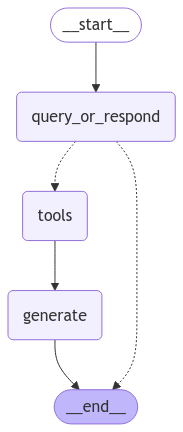

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))
